In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import os

from scipy import spatial
from scipy import sparse
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from umap import UMAP

import json

In [2]:
import importlib

from scroutines import powerplots
from scroutines.miscu import is_in_polygon

import utils_merfish
importlib.reload(utils_merfish)
from utils_merfish import rot2d, st_scatter, st_scatter_ax, plot_cluster, binning
from utils_merfish import RefLineSegs

import merfish_datasets
import merfish_genesets
importlib.reload(merfish_datasets)
from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params

from scroutines import basicu

In [3]:
def get_qc_metrics(df):
    """
    return metrics
     - key
      - (name, val, medval, bins)
    """
    metrics = {}
    cols  = ['volume', 'gncov', 'gnnum']
    names = ['cell volume', 'num transcripts', 'num genes']
    
    for col, name in zip(cols, names):
        val = df[col].values
        medval = np.median(val)
        bins = np.linspace(0, 10*medval, 50)
        
        metrics[col] = (name, val, medval, bins)
    return metrics

def get_norm_counts(adata, scaling=500):
    """norm - equalize the volume to be 500 for all cells
    """
    cnts = adata.X
    vol = adata.obs['volume'].values
    normcnts = cnts/vol.reshape(-1,1)*scaling
    adata.layers['norm'] = normcnts
    
    return normcnts

In [4]:
def get_largest_spatial_components(adata, k=100, dist_th=80):
    """
    k - number of neighbors
    dist_th - distance to call connected components
    
    returns
        - indices of the largest components
    """
    XY = adata.obs[['x', 'y']].values
    nc = len(XY)

    # kNN
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(XY)
    distances, indices = nbrs.kneighbors(XY)

    # filtered by distance th
    val = distances[:,1:].reshape(-1,)
    i = np.repeat(indices[:,0],k-1)
    j = indices[:,1:].reshape(-1,)

    indices_filtered = np.vstack([i[val < dist_th], j[val < dist_th]]).T

    G = nx.Graph()
    G.add_nodes_from(np.arange(nc))
    G.add_edges_from(indices_filtered)
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    indices_selected = np.array(list(largest_component))

    print(f"fraction of cells included: {len(largest_component)/nc: .2f}" )
    
    return indices_selected, XY

In [5]:
def preprocessing(adata):
    # filter genes
    cond = np.ravel((adata.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
    adata_sub = adata[:,cond]

    # counts
    x = adata_sub.X
    cov = adata_sub.obs['n_counts'].values

    # CP10k
    xn = (sparse.diags(1/cov).dot(x))*1e4

    # log10(CP10k+1)
    xln = xn.copy()
    xln.data = np.log10(xln.data+1)

    adata_sub.layers['norm'] = xn
    adata_sub.layers['lognorm'] = xln
    
    return adata_sub

In [6]:
def get_hvgs(adata, layer, nbin=20, qth=0.3):
    """
    """
    xn = adata.layers[layer]
    
    # min
    gm = np.ravel(xn.mean(axis=0))

    # var
    tmp = xn.copy()
    tmp.data = np.power(tmp.data, 2)
    gv = np.ravel(tmp.mean(axis=0))-gm**2

    # cut 
    lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
    gres = pd.DataFrame()
    gres['lbl'] = lbl
    gres['mean'] = gm
    gres['var'] = gv
    gres['ratio']= gv/gm

    # select
    gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
    gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)

    assert np.all(gsel_idx != -1)
    
    return adata.var.index.values[gsel_idx]

In [7]:
def neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(ref_emb)
    dists, idx = neigh.kneighbors(qry_emb, k, return_distance=True)
    
    raw_pred = ref_lbl[idx]

    # p
    pabc = np.empty((qry_n, n_unq_lbls))
    for i, lbl in enumerate(unq_lbls):
        p = np.sum(raw_pred==lbl, axis=1)/k
        pabc[:,i] = p

    # max
    max_pred = unq_lbls[np.argmax(pabc, axis=1)]

    # 
    gated_pred = max_pred.copy()
    cond1 = np.max( pabc, axis=1) > p_cutoff
    gated_pred[~cond1] = 'NA' 
    if dist_cutoff is not None:
        cond2 = np.max(dists, axis=1) < dist_cutoff
        gated_pred[~cond2] = 'NA' 
    
    return max_pred, gated_pred, np.max(dists, axis=1)


def neighbor_self_nonself(k, ref_emb, qry_emb):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    lbls = np.array([0]*ref_n+[1]*qry_n)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(np.vstack([ref_emb, qry_emb]))
    idx = neigh.kneighbors(qry_emb, k, return_distance=False)
    
    isself = lbls[idx]

    p = np.sum(isself, axis=1)/k

    
    return p # max_pred, gated_pred, np.max(dists, axis=1)

# load data and construct adata 

In [8]:
np.random.seed(0)

In [9]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized"
!mkdir -p $outdir
!mkdir -p $outdatadir

In [10]:
genesets, df = merfish_genesets.get_all_genesets()
for key, item in genesets.items():
    print(key, len(item))

a 64
b 35
c 71
i 16
a_up 14


In [11]:
ddir  = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized" 
fin  = os.path.join(ddir, 'P28NRDR_v1_rna_merfish_240729.h5ad')
fin2 = os.path.join(ddir, 'P28NRDR_v1glut_rna_merfish_240729.h5ad')
fin3 = os.path.join(ddir, 'P28NRDR_v1l23glut_rna_merfish_240729.h5ad')
fin4 = os.path.join(ddir, 'P28NRDR_v1gaba_rna_merfish_240729.h5ad')
!ls $ddir/*l2*240723.h5ad 

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRa_ant_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRa_pos_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRb_ant_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRb_pos_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_ant_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_pos_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRb_ant_l2_v1_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRb_pos_l2_v1_240723.h5ad


In [12]:
adata_merge_all = sc.read(fin)
adata_merfish_all = adata_merge_all[adata_merge_all.obs['modality']=='merfish']
adata_snrnasq_all = adata_merge_all[adata_merge_all.obs['modality']=='rna']
adata_merge_all, adata_merfish_all, adata_snrnasq_all

(AnnData object with n_obs × n_vars = 67891 × 361
     obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'modality', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3', 'umap1', 'umap2', 'umap1_self', 'umap2_self', 'max_pred', 'frac_self_neighbors', 'gated_pred'
     uns: 'neighbors', 'umap'
     obsm: 'X_pca', 'X_pca2', 'X_pca_harmony', 'X_umap', 'X_xy', 'blanks', 'pca', 'umap'
     layers: 'jnorm', 'ljnorm', 'lognorm', 'norm'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 439

In [13]:
adata_merge_inh = sc.read(fin4)
adata_merfish_inh = adata_merge_inh[adata_merge_inh.obs['modality']=='merfish']
adata_snrnasq_inh = adata_merge_inh[adata_merge_inh.obs['modality']=='rna']
adata_merge_inh, adata_merfish_inh, adata_snrnasq_inh

(AnnData object with n_obs × n_vars = 5212 × 361
     obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'modality', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3', 'umap1', 'umap2', 'umap1_self', 'umap2_self', 'max_pred', 'frac_self_neighbors', 'gated_pred', 'Subclass_new', 'max_pred_subclass', 'frac_self_neighbors_subclass', 'gated_pred_subclass'
     uns: 'neighbors', 'umap'
     obsm: 'X_pca', 'X_pca2', 'X_pca_harmony', 'X_umap', 'X_xy', 'blanks', 'pca', 'umap'
     layers: 'jnorm', 'ljnorm', 'lognorm', 'norm'


In [14]:
# adata_merge = sc.read(fout)
adata_merge_exc = sc.read(fin2)
adata_merfish = adata_merge_exc[adata_merge_exc.obs['modality']=='merfish']
adata_snrnasq = adata_merge_exc[adata_merge_exc.obs['modality']=='rna']
adata_merge_exc, adata_merfish, adata_snrnasq

(AnnData object with n_obs × n_vars = 36376 × 361
     obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'modality', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3', 'umap1', 'umap2', 'umap1_self', 'umap2_self', 'max_pred', 'frac_self_neighbors', 'gated_pred', 'max_pred_subclass', 'frac_self_neighbors_subclass', 'gated_pred_subclass'
     uns: 'neighbors', 'umap'
     obsm: 'X_pca', 'X_pca2', 'X_pca_harmony', 'X_umap', 'X_xy', 'blanks', 'pca', 'umap'
     layers: 'jnorm', 'ljnorm', 'lognorm', 'norm'
     obsp: 'con

# all

In [15]:
x =   adata_merfish_all.obs['width']
y =  -adata_merfish_all.obs['depth']
ux =  adata_merfish_all.obsm['X_umap'][:,0]
uy =  adata_merfish_all.obsm['X_umap'][:,1]
clsts_lbl = adata_merfish_all.obs['gated_pred'].values
ref_lbl   = adata_snrnasq_all.obs['Class_broad'].values
clsts, _  = pd.factorize(clsts_lbl) # .astype(int) # requires [0,1,2...,N]
clsts_palette, clsts_cmap = utils_merfish.generate_discrete_cmap([len(np.unique(clsts))], keys=['tab20',])

csel = 'tab20'
clsts_palette1 = {clst: color for clst, color in zip(np.unique(ref_lbl), clsts_palette)}
clsts_palette1['NA'] = 'gray'

0.1963103660062328
saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/figs1_scatter_all_2024-08-08.pdf


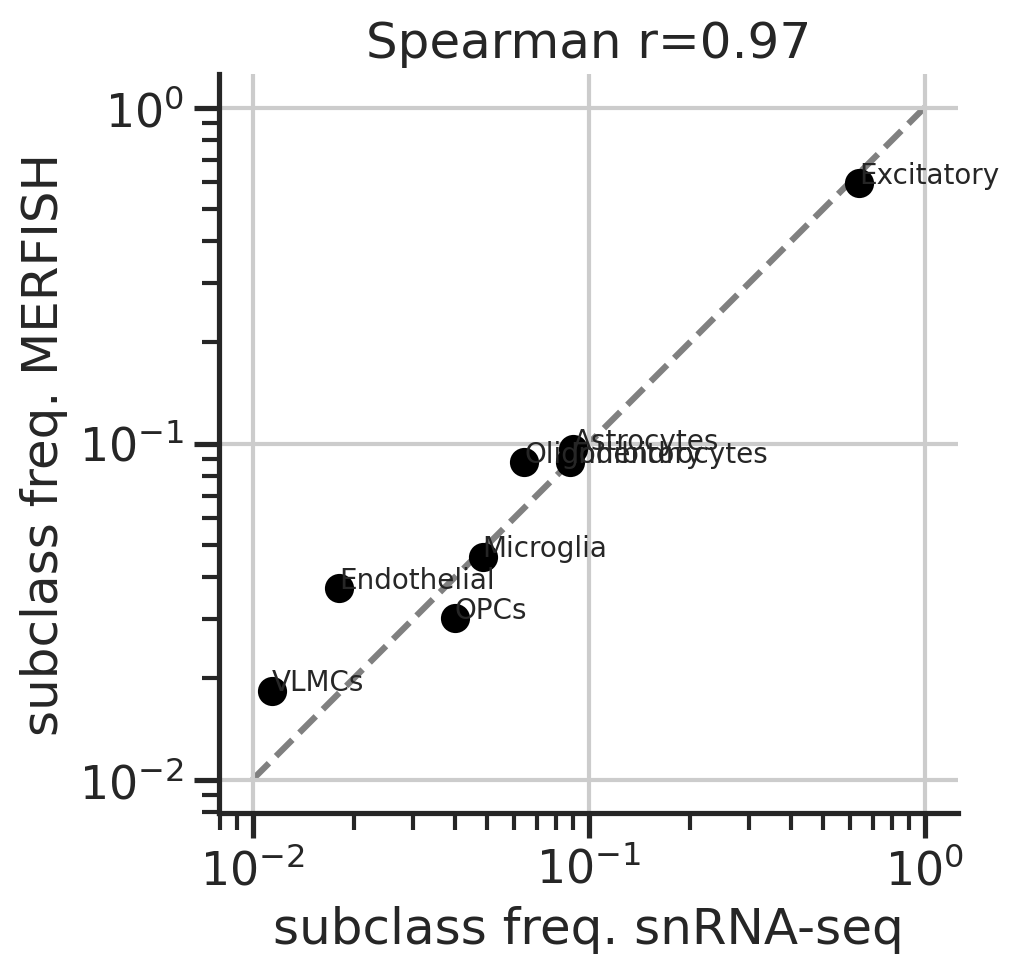

In [16]:
m = adata_snrnasq_all.obs['Class_broad'].value_counts() # /len(adata_rna)
m = m/m.sum()
n = adata_merfish_all.obs['gated_pred'].value_counts() # /len(adata_mer)).loc[m.index]
print(n.loc['NA']/n.sum())
n = n.loc[m.index]
n = n/n.sum()

fig, ax = plt.subplots()
ax.scatter(m, n, color='k')
r, p = stats.spearmanr(m.values, n.values)
for i in range(len(m)):
    ax.text(m.iloc[i], n.iloc[i], m.index.values[i], fontsize=10)
    
ax.set_title(f"Spearman r={r:.2g}")

ax.plot([1e-2, 1], [1e-2, 1], '--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_xticks([0,0.1])
ax.set_yticks([0,0.1])
sns.despine(ax=ax)

ax.set_xlabel('subclass freq. snRNA-seq')
ax.set_ylabel('subclass freq. MERFISH')
ax.set_xscale('log')
ax.set_yscale('log')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'figs1_scatter_all.pdf'))
                            
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_umap_all_2024-08-08.pdf


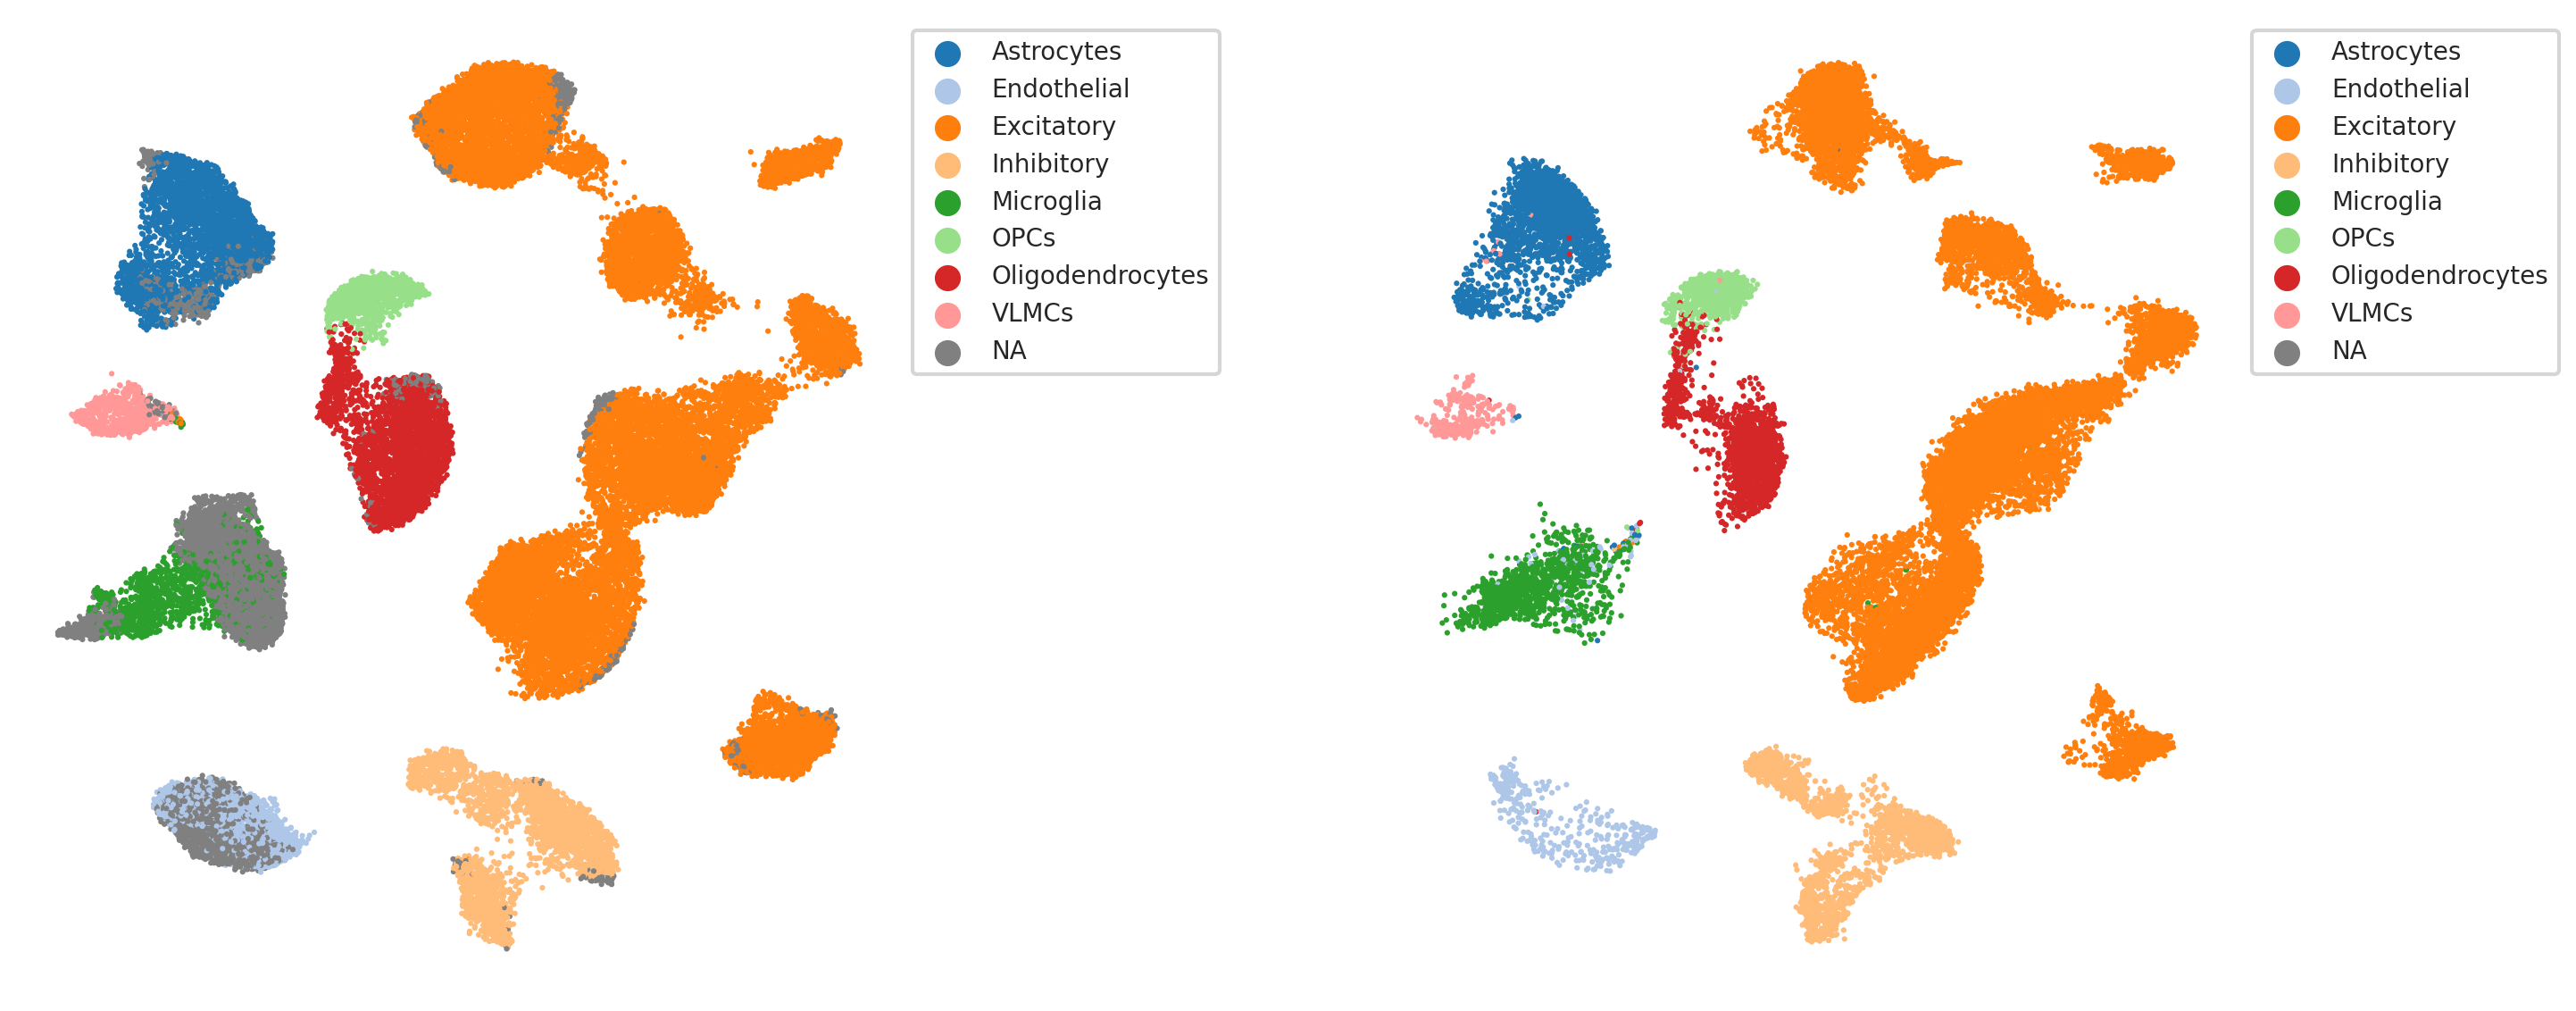

In [17]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6), sharex=True, sharey=True)
for ax, adata_mod, col, x, y in zip(axs, 
                              [adata_merfish_all, adata_snrnasq_all], 
                              ['gated_pred', 'Class_broad'],
                              ['umap1', 'umap1'],
                              ['umap2', 'umap2'],
                             ):
    sns.scatterplot(data=adata_mod.obs.sample(frac=1, replace=False), 
                    x=x, y=y, 
                    hue=col, 
                    palette=clsts_palette1, hue_order=list(clsts_palette1.keys()),
                    s=5, edgecolor='none', ax=ax, rasterized=True)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1,1), fontsize=10)
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_umap_all.pdf'))
fig.tight_layout()
plt.show()



saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_dw_all_2024-08-08.pdf


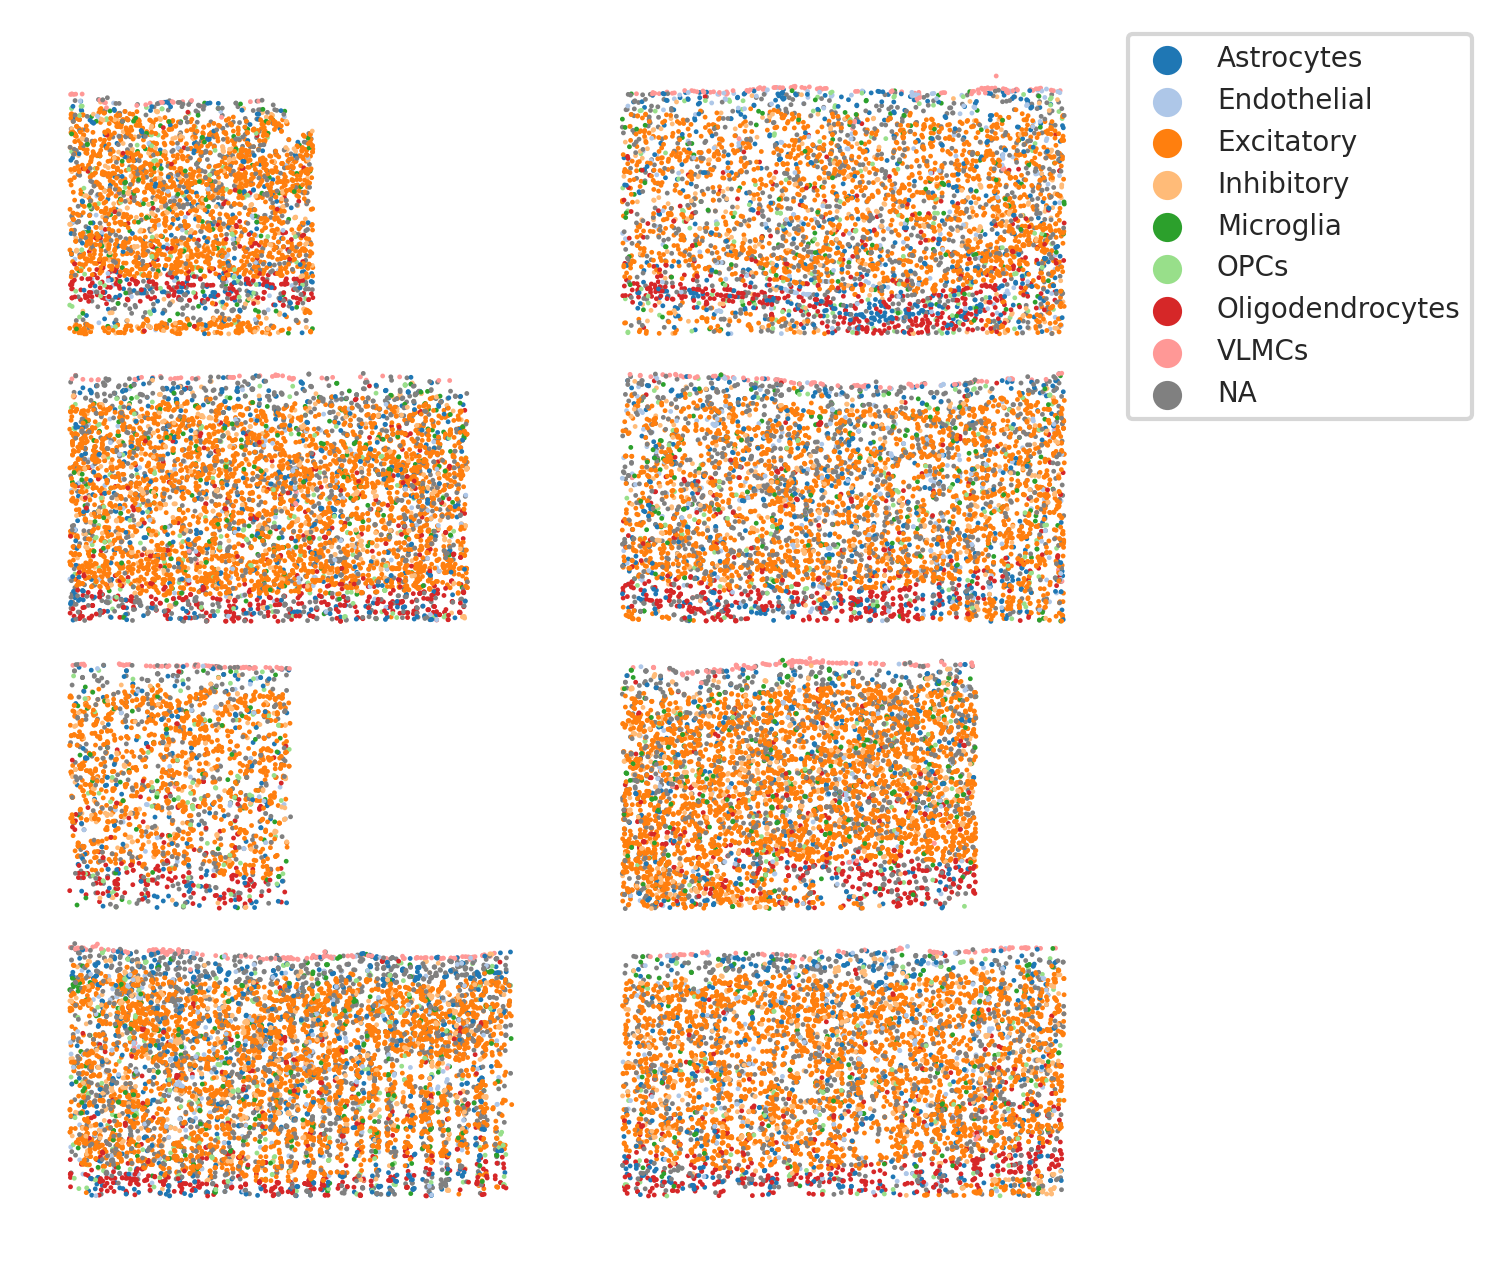

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata_merfish_all.obs.sample(frac=1, replace=False), 
                x='width_show', y='depth_show', 
                hue='gated_pred', 
                palette=clsts_palette1, hue_order=list(clsts_palette1.keys()),
                s=3, edgecolor='none', ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(1,1), fontsize=10)
ax.axis('off')
ax.set_aspect('equal')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_dw_all.pdf'))
plt.show()

# inh
- note this: `subclass` -> `subclass_new`

In [19]:
x =   adata_merfish_inh.obs['width']
y =  -adata_merfish_inh.obs['depth']
ux =  adata_merfish_inh.obsm['X_umap'][:,0]
uy =  adata_merfish_inh.obsm['X_umap'][:,1]
clsts_lbl = adata_merfish_inh.obs['max_pred_subclass'].values
ref_lbl   = adata_snrnasq_inh.obs['Subclass_new'].values
clsts, _  = pd.factorize(clsts_lbl) # .astype(int) # requires [0,1,2...,N]
clsts_palette, clsts_cmap = utils_merfish.generate_discrete_cmap([len(np.unique(clsts))], keys=['tab20',])

csel = 'tab20'
clsts_palette2 = {clst: color for clst, color in zip(np.unique(ref_lbl), clsts_palette)}
# clsts_palette2['NA'] = 'gray'

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/figs1_scatter_inh_2024-08-08.pdf


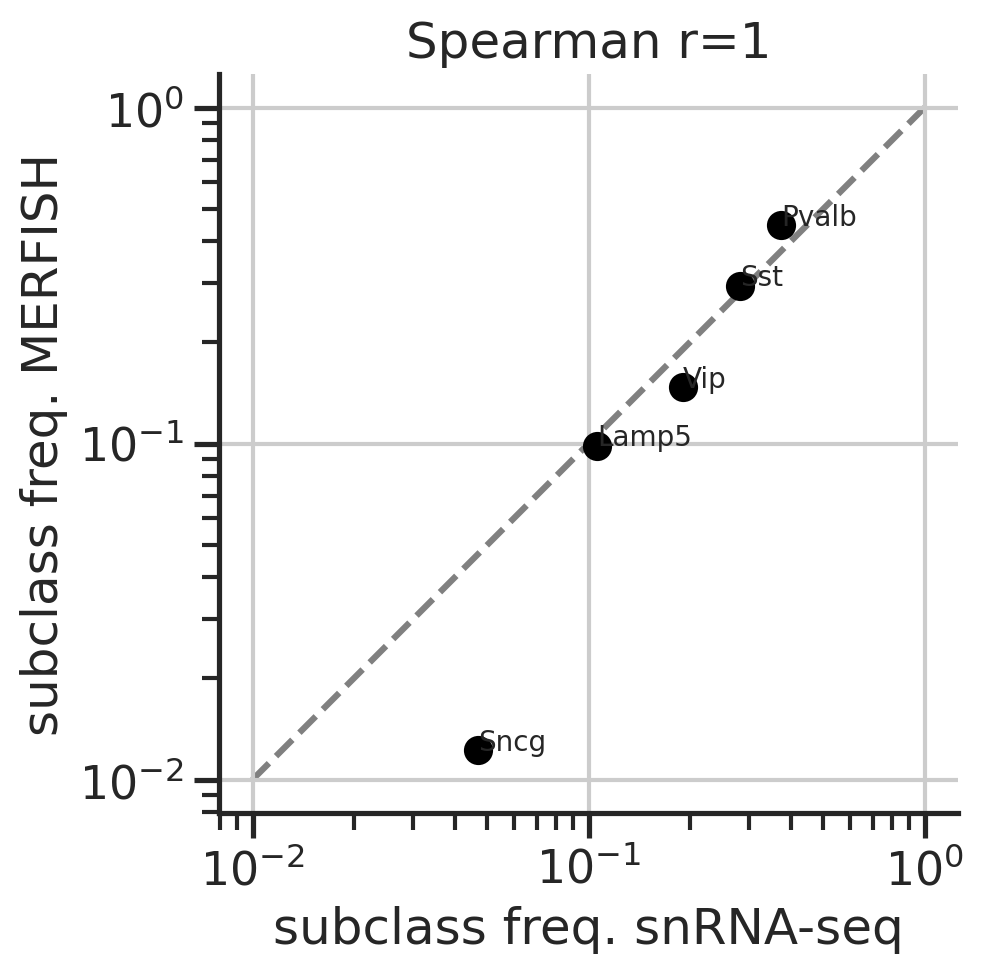

In [20]:
m = adata_snrnasq_inh.obs['Subclass_new'].value_counts() # /len(adata_rna)
m = m/m.sum()
n = adata_merfish_inh.obs['max_pred_subclass'].value_counts() # /len(adata_mer)).loc[m.index]
# print(n.loc['NA']/n.sum())
n = n.loc[m.index]
n = n/n.sum()

fig, ax = plt.subplots()
ax.scatter(m, n, color='k')
r, p = stats.spearmanr(m.values, n.values)
for i in range(len(m)):
    ax.text(m.iloc[i], n.iloc[i], m.index.values[i], fontsize=10)
    
ax.set_title(f"Spearman r={r:.2g}")

ax.plot([1e-2, 1], [1e-2, 1], '--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_xticks([0,0.1])
ax.set_yticks([0,0.1])
sns.despine(ax=ax)

ax.set_xlabel('subclass freq. snRNA-seq')
ax.set_ylabel('subclass freq. MERFISH')
ax.set_xscale('log')
ax.set_yscale('log')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'figs1_scatter_inh.pdf'))
                            
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_umap_inh_2024-08-08.pdf


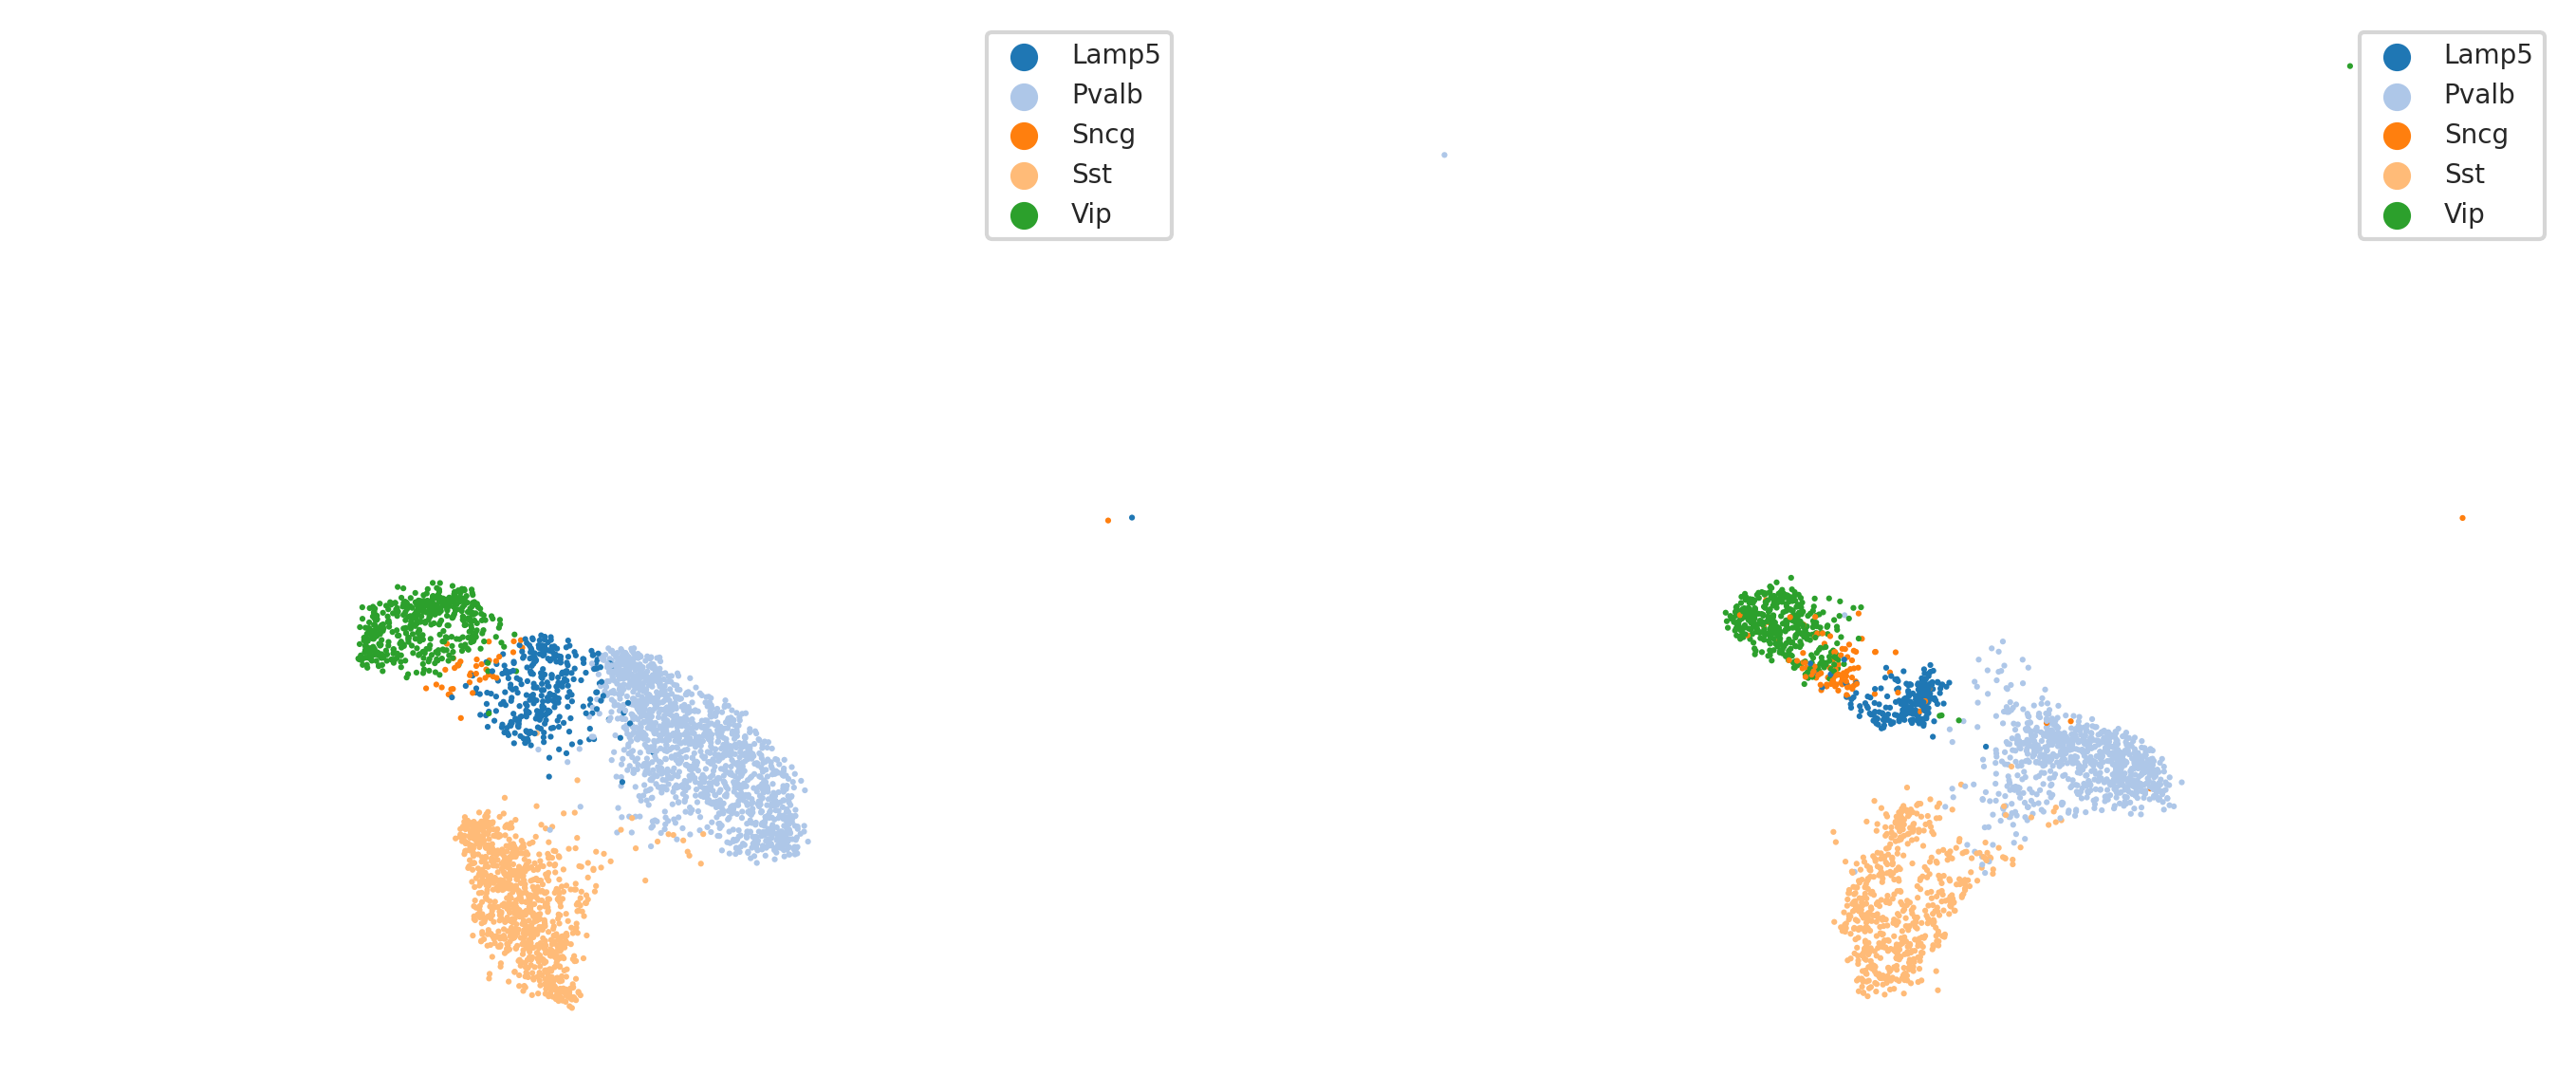

In [21]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6), sharex=True, sharey=True)
for ax, adata_mod, col, x, y in zip(axs, 
                              [adata_merfish_inh, adata_snrnasq_inh], 
                              ['max_pred_subclass', 'Subclass_new'],
                              ['umap1', 'umap1'],
                              ['umap2', 'umap2'],
                             ):
    sns.scatterplot(data=adata_mod.obs.sample(frac=1, replace=False), 
                    x=x, y=y, 
                    hue=col, 
                    palette=clsts_palette2, hue_order=list(clsts_palette2.keys()),
                    s=5, edgecolor='none', ax=ax, rasterized=True)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1,1), fontsize=10)
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_umap_inh.pdf'))
fig.tight_layout()
plt.show()



saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_dw_inh_2024-08-08.pdf


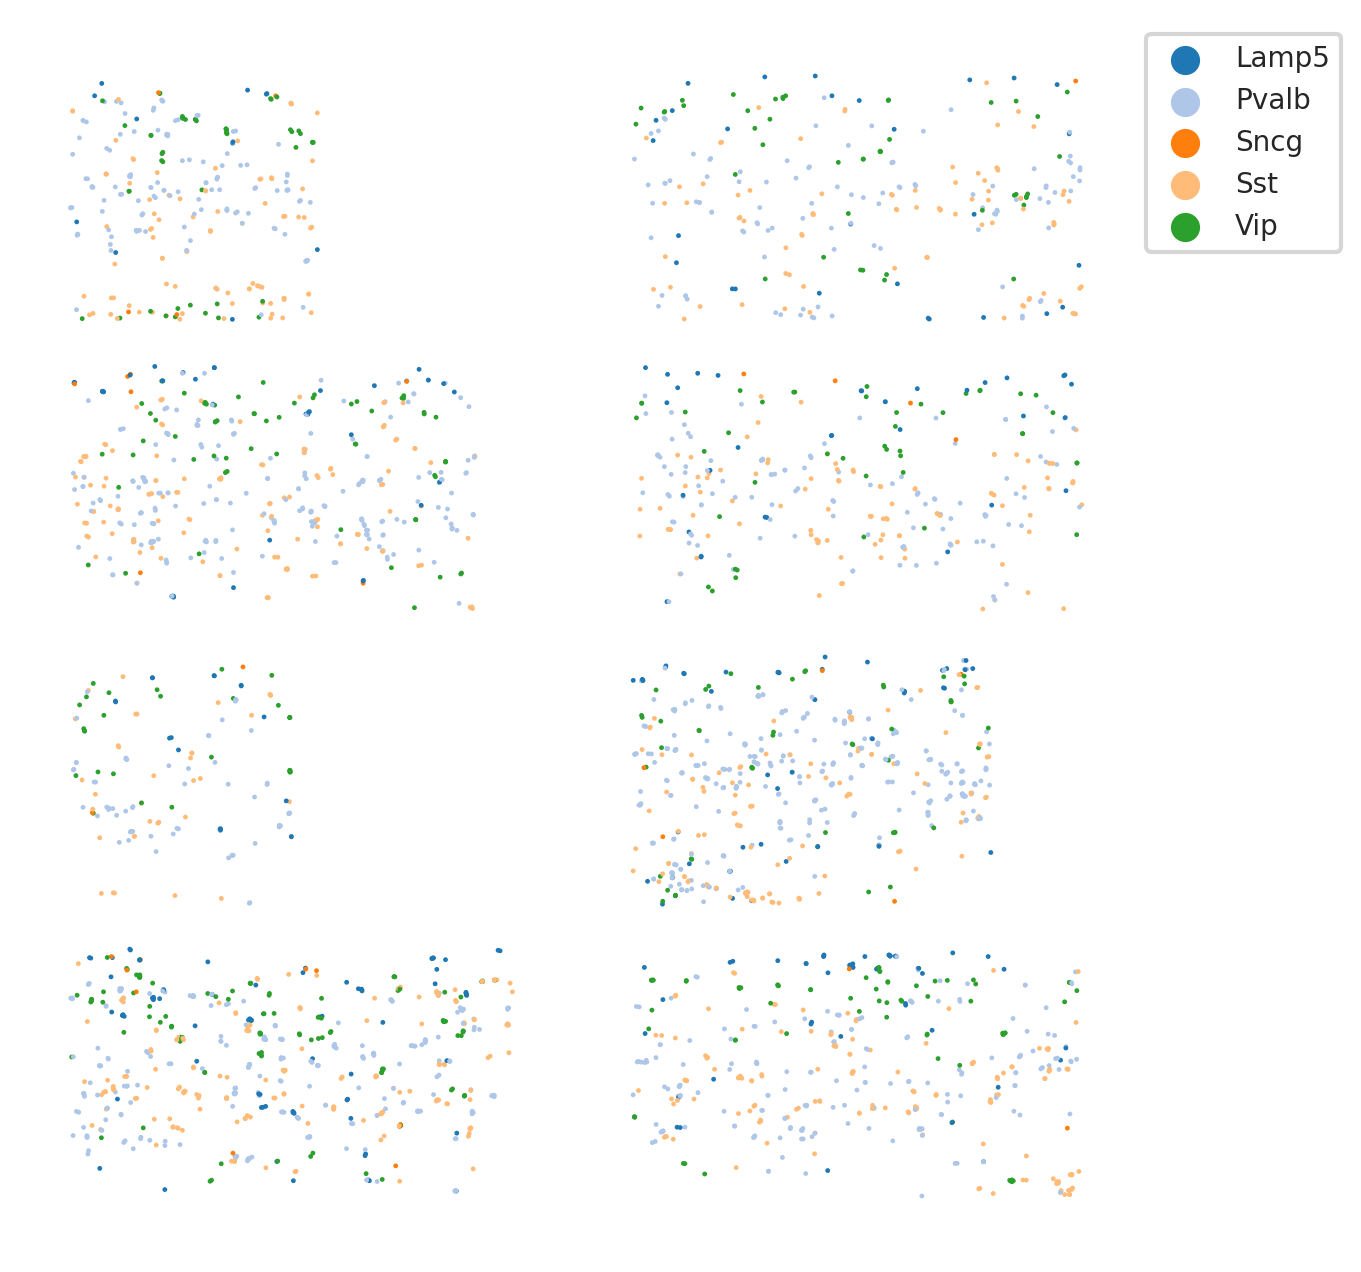

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata_merfish_inh.obs.sample(frac=1, replace=False), 
                x='width_show', y='depth_show', 
                hue='max_pred_subclass', 
                palette=clsts_palette2, hue_order=list(clsts_palette2.keys()),
                s=3, edgecolor='none', ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(1,1), fontsize=10)
ax.axis('off')
ax.set_aspect('equal')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_dw_inh.pdf'))
plt.show()

# exc

In [23]:
x =   adata_merfish.obs['width']
y =  -adata_merfish.obs['depth']
ux =  adata_merfish.obsm['X_umap'][:,0]
uy =  adata_merfish.obsm['X_umap'][:,1]
clsts_lbl = adata_merfish.obs['max_pred_subclass'].values
ref_lbl   = adata_snrnasq.obs['Subclass'].values
clsts, _ = pd.factorize(clsts_lbl) # .astype(int) # requires [0,1,2...,N]
clsts_palette, clsts_cmap = utils_merfish.generate_discrete_cmap([len(np.unique(clsts))], keys=['tab20',])

csel = 'tab20'
clsts_palette3 = {clst: color for clst, color in zip(np.unique(ref_lbl), clsts_palette)}
# clsts_palette3['NA'] = 'gray'

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/figs1_scatter_exc_2024-08-08.pdf


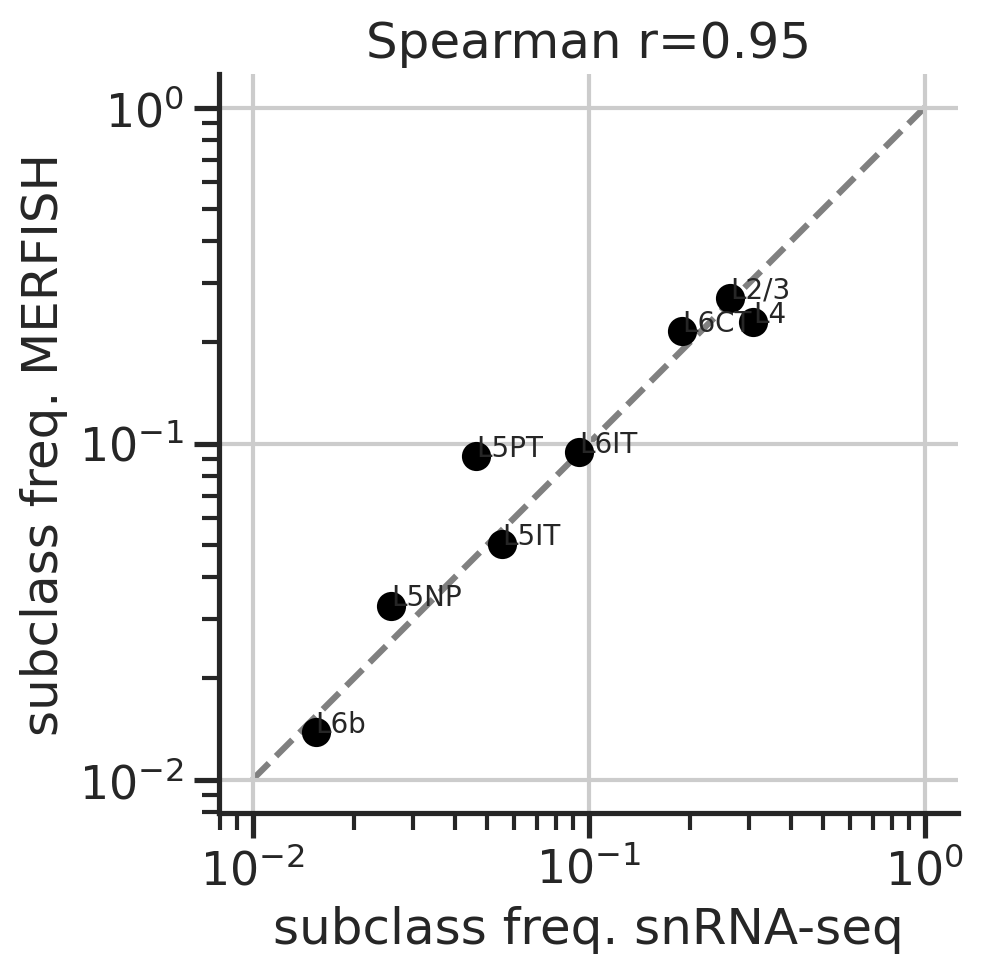

In [24]:
m = adata_snrnasq.obs['Subclass'].value_counts() # /len(adata_rna)
m = m/m.sum()
n = adata_merfish.obs['max_pred_subclass'].value_counts() # /len(adata_mer)).loc[m.index]
# print(n.loc['NA']/n.sum())
n = n.loc[m.index]
n = n/n.sum()

fig, ax = plt.subplots()
ax.scatter(m, n, color='k')
r, p = stats.spearmanr(m.values, n.values)
for i in range(len(m)):
    ax.text(m.iloc[i], n.iloc[i], m.index.values[i], fontsize=10)
    
ax.set_title(f"Spearman r={r:.2g}")

ax.plot([1e-2, 1], [1e-2, 1], '--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_xticks([0,0.1])
ax.set_yticks([0,0.1])
sns.despine(ax=ax)

ax.set_xlabel('subclass freq. snRNA-seq')
ax.set_ylabel('subclass freq. MERFISH')
ax.set_xscale('log')
ax.set_yscale('log')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'figs1_scatter_exc.pdf'))
                            
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_umap_exc_2024-08-08.pdf


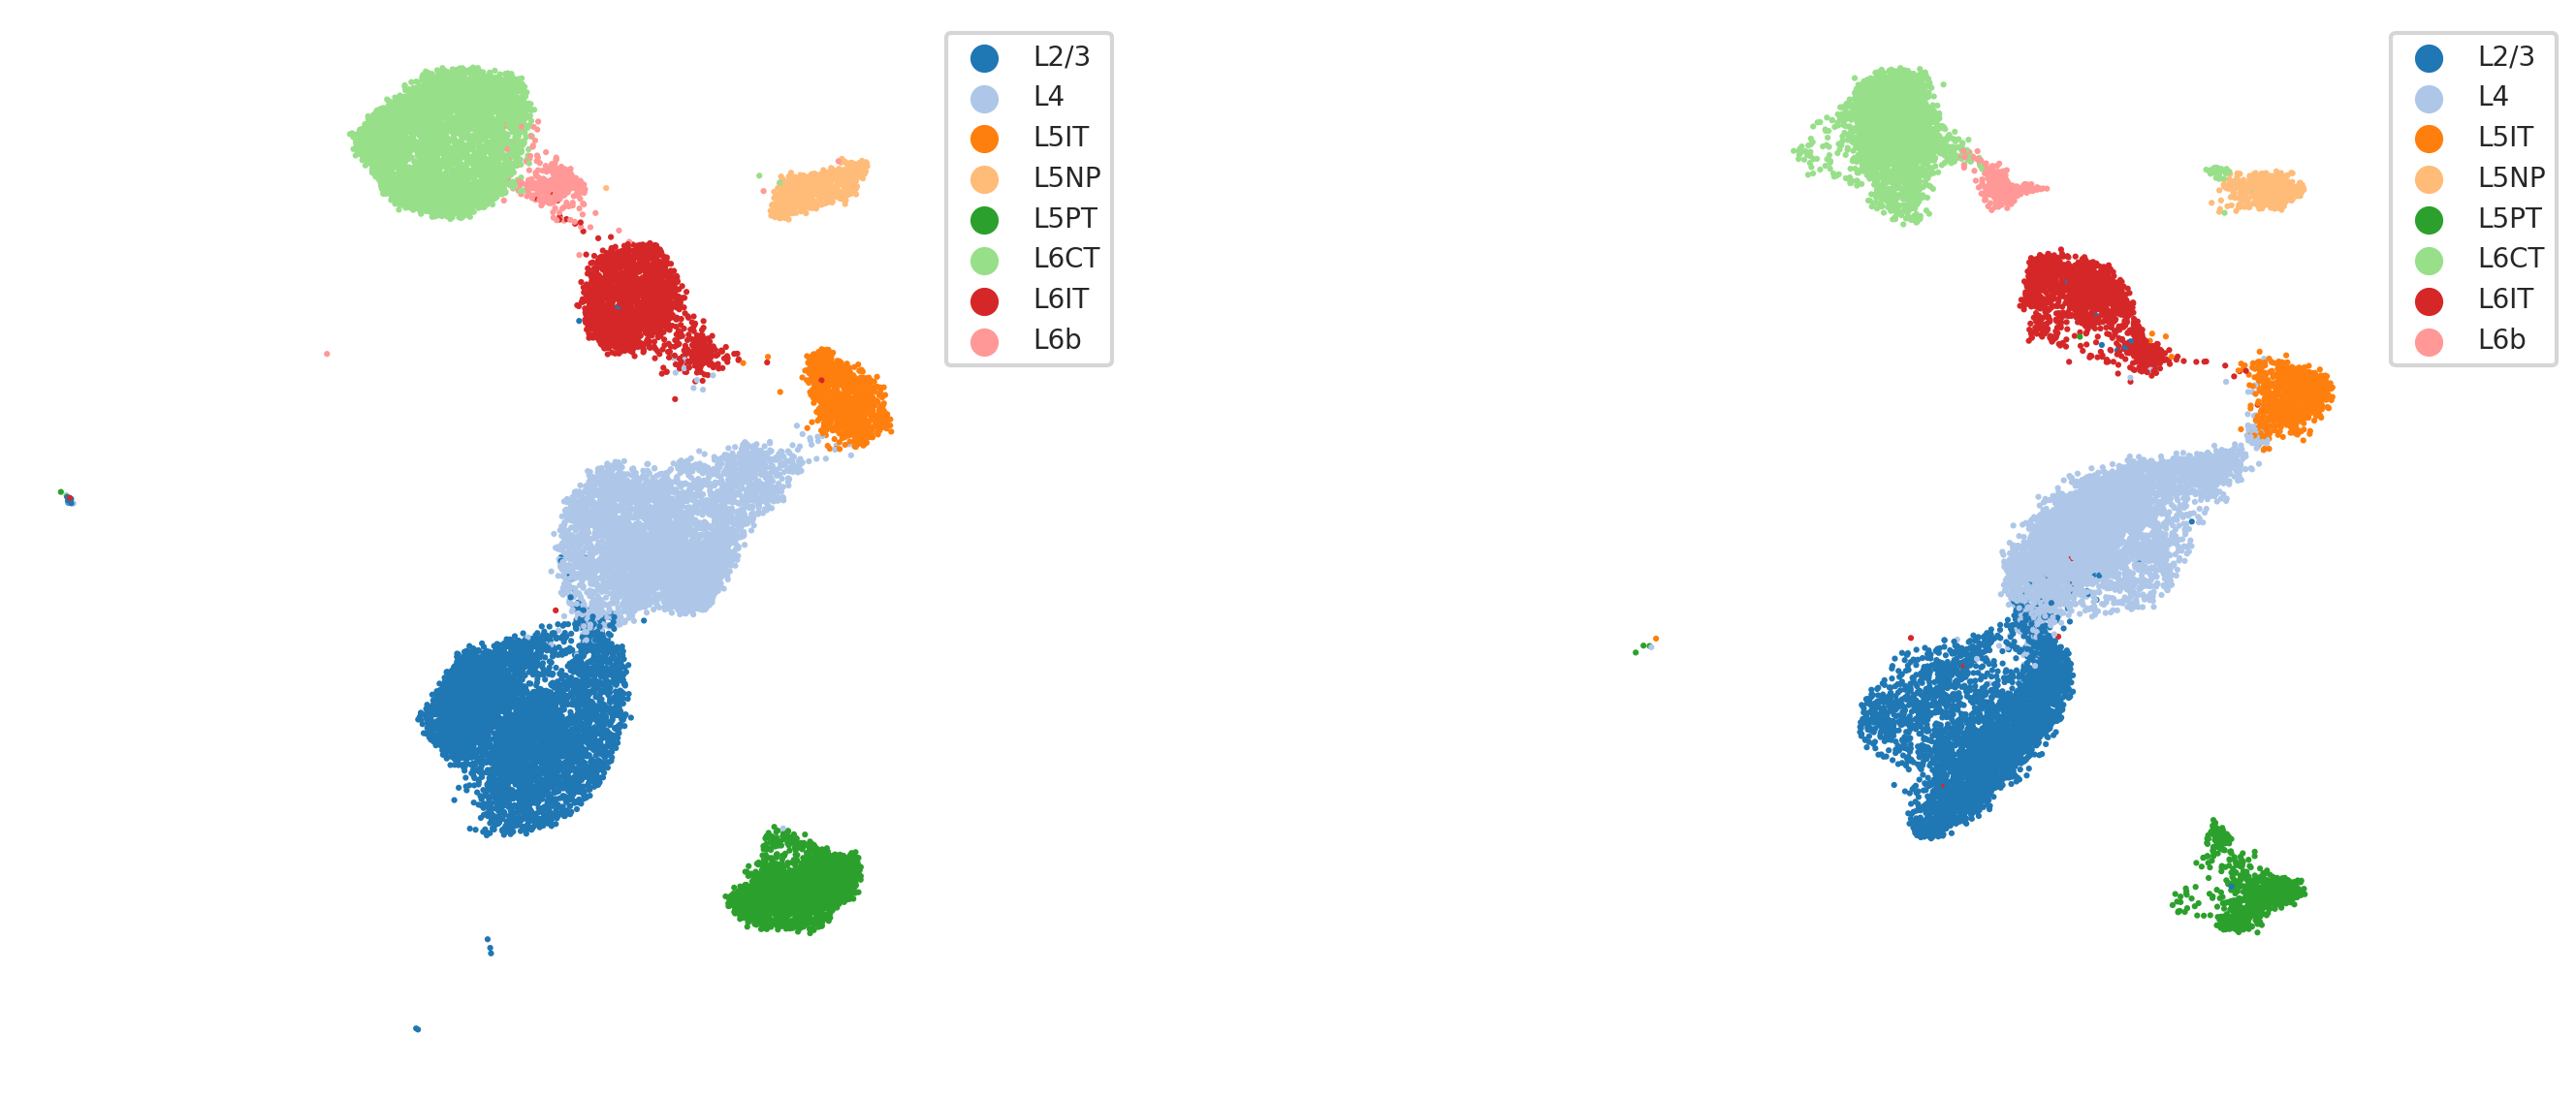

In [25]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6), sharex=True, sharey=True)
for ax, adata_mod, col, x, y in zip(axs, 
                              [adata_merfish, adata_snrnasq], 
                              ['max_pred_subclass', 'Subclass'], 
                              ['umap1', 'umap1'],
                              ['umap2', 'umap2'],
                             ):
    sns.scatterplot(data=adata_mod.obs.sample(frac=1, replace=False), 
                    x=x, y=y, 
                    hue=col, 
                    palette=clsts_palette3, hue_order=list(clsts_palette3.keys()),
                    s=5, edgecolor='none', ax=ax, rasterized=True)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1,1), fontsize=10)
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_umap_exc.pdf'))
fig.tight_layout()
plt.show()



saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig1_dw_exc_2024-08-08.pdf


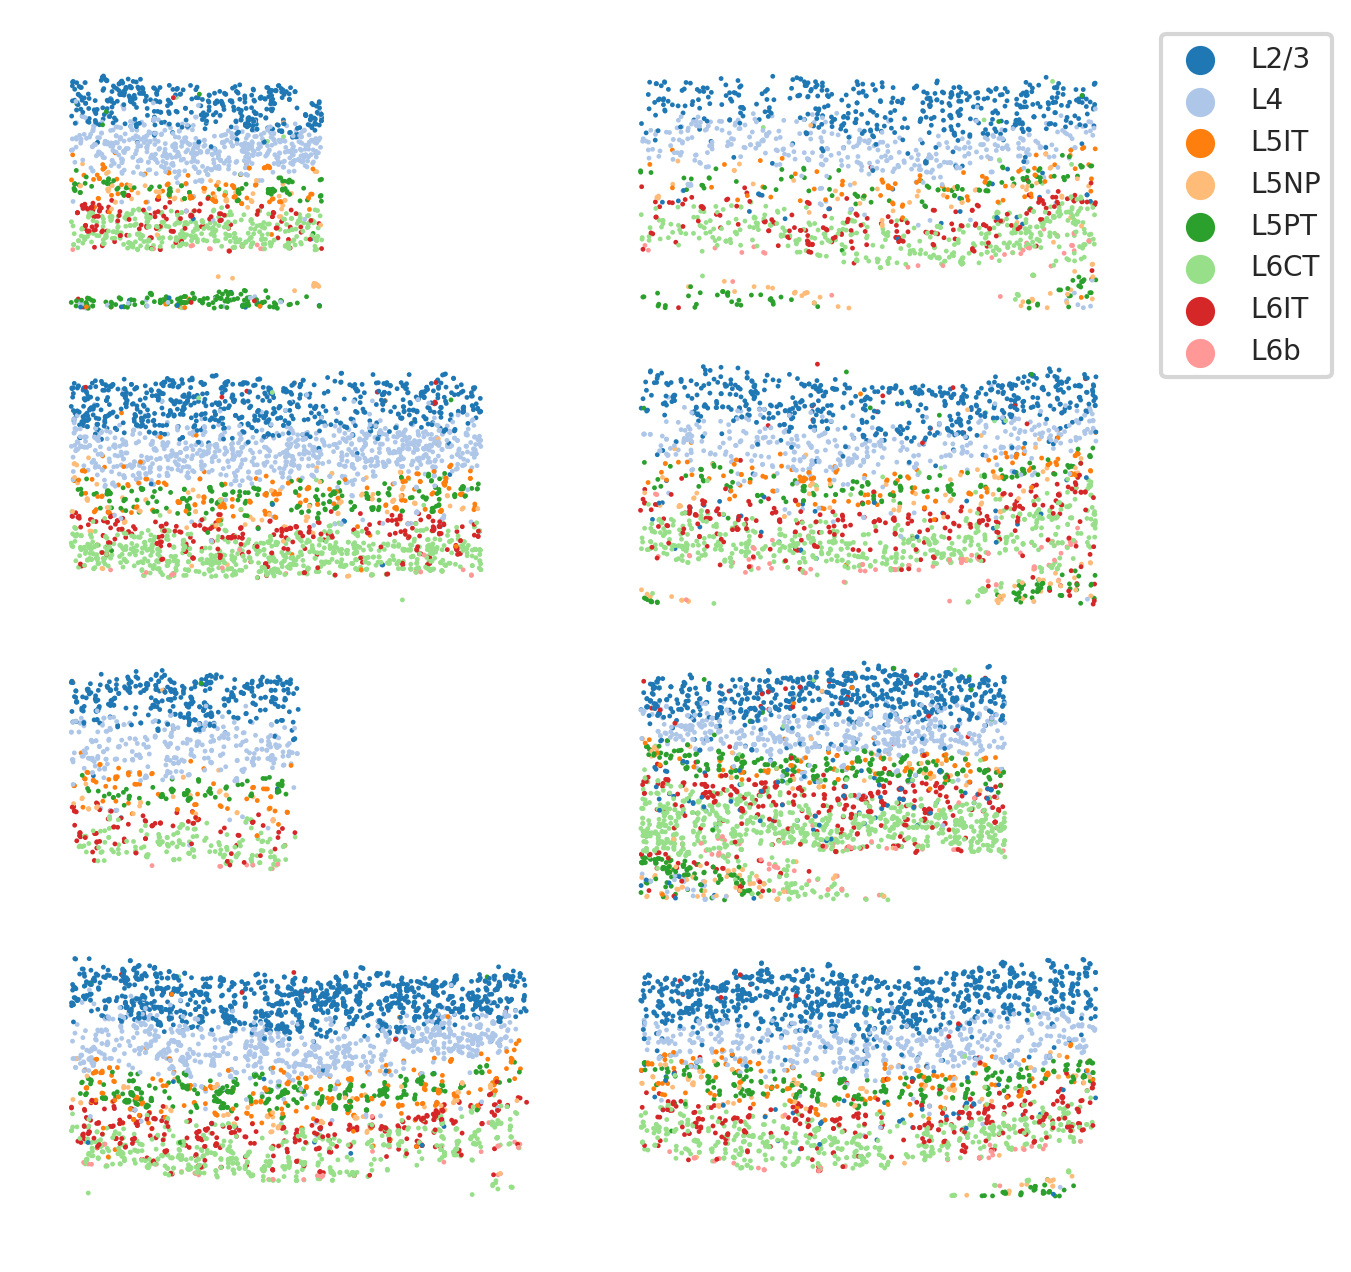

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata_merfish.obs.sample(frac=1, replace=False), 
                x='width_show', y='depth_show', 
                hue='max_pred_subclass', 
                palette=clsts_palette3, hue_order=list(clsts_palette3.keys()),
                s=3, edgecolor='none', ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(1,1), fontsize=10)
ax.axis('off')
ax.set_aspect('equal')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_dw_exc.pdf'))
plt.show()

['L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT', 'L6IT', 'L6b']


IndexError: list index out of range

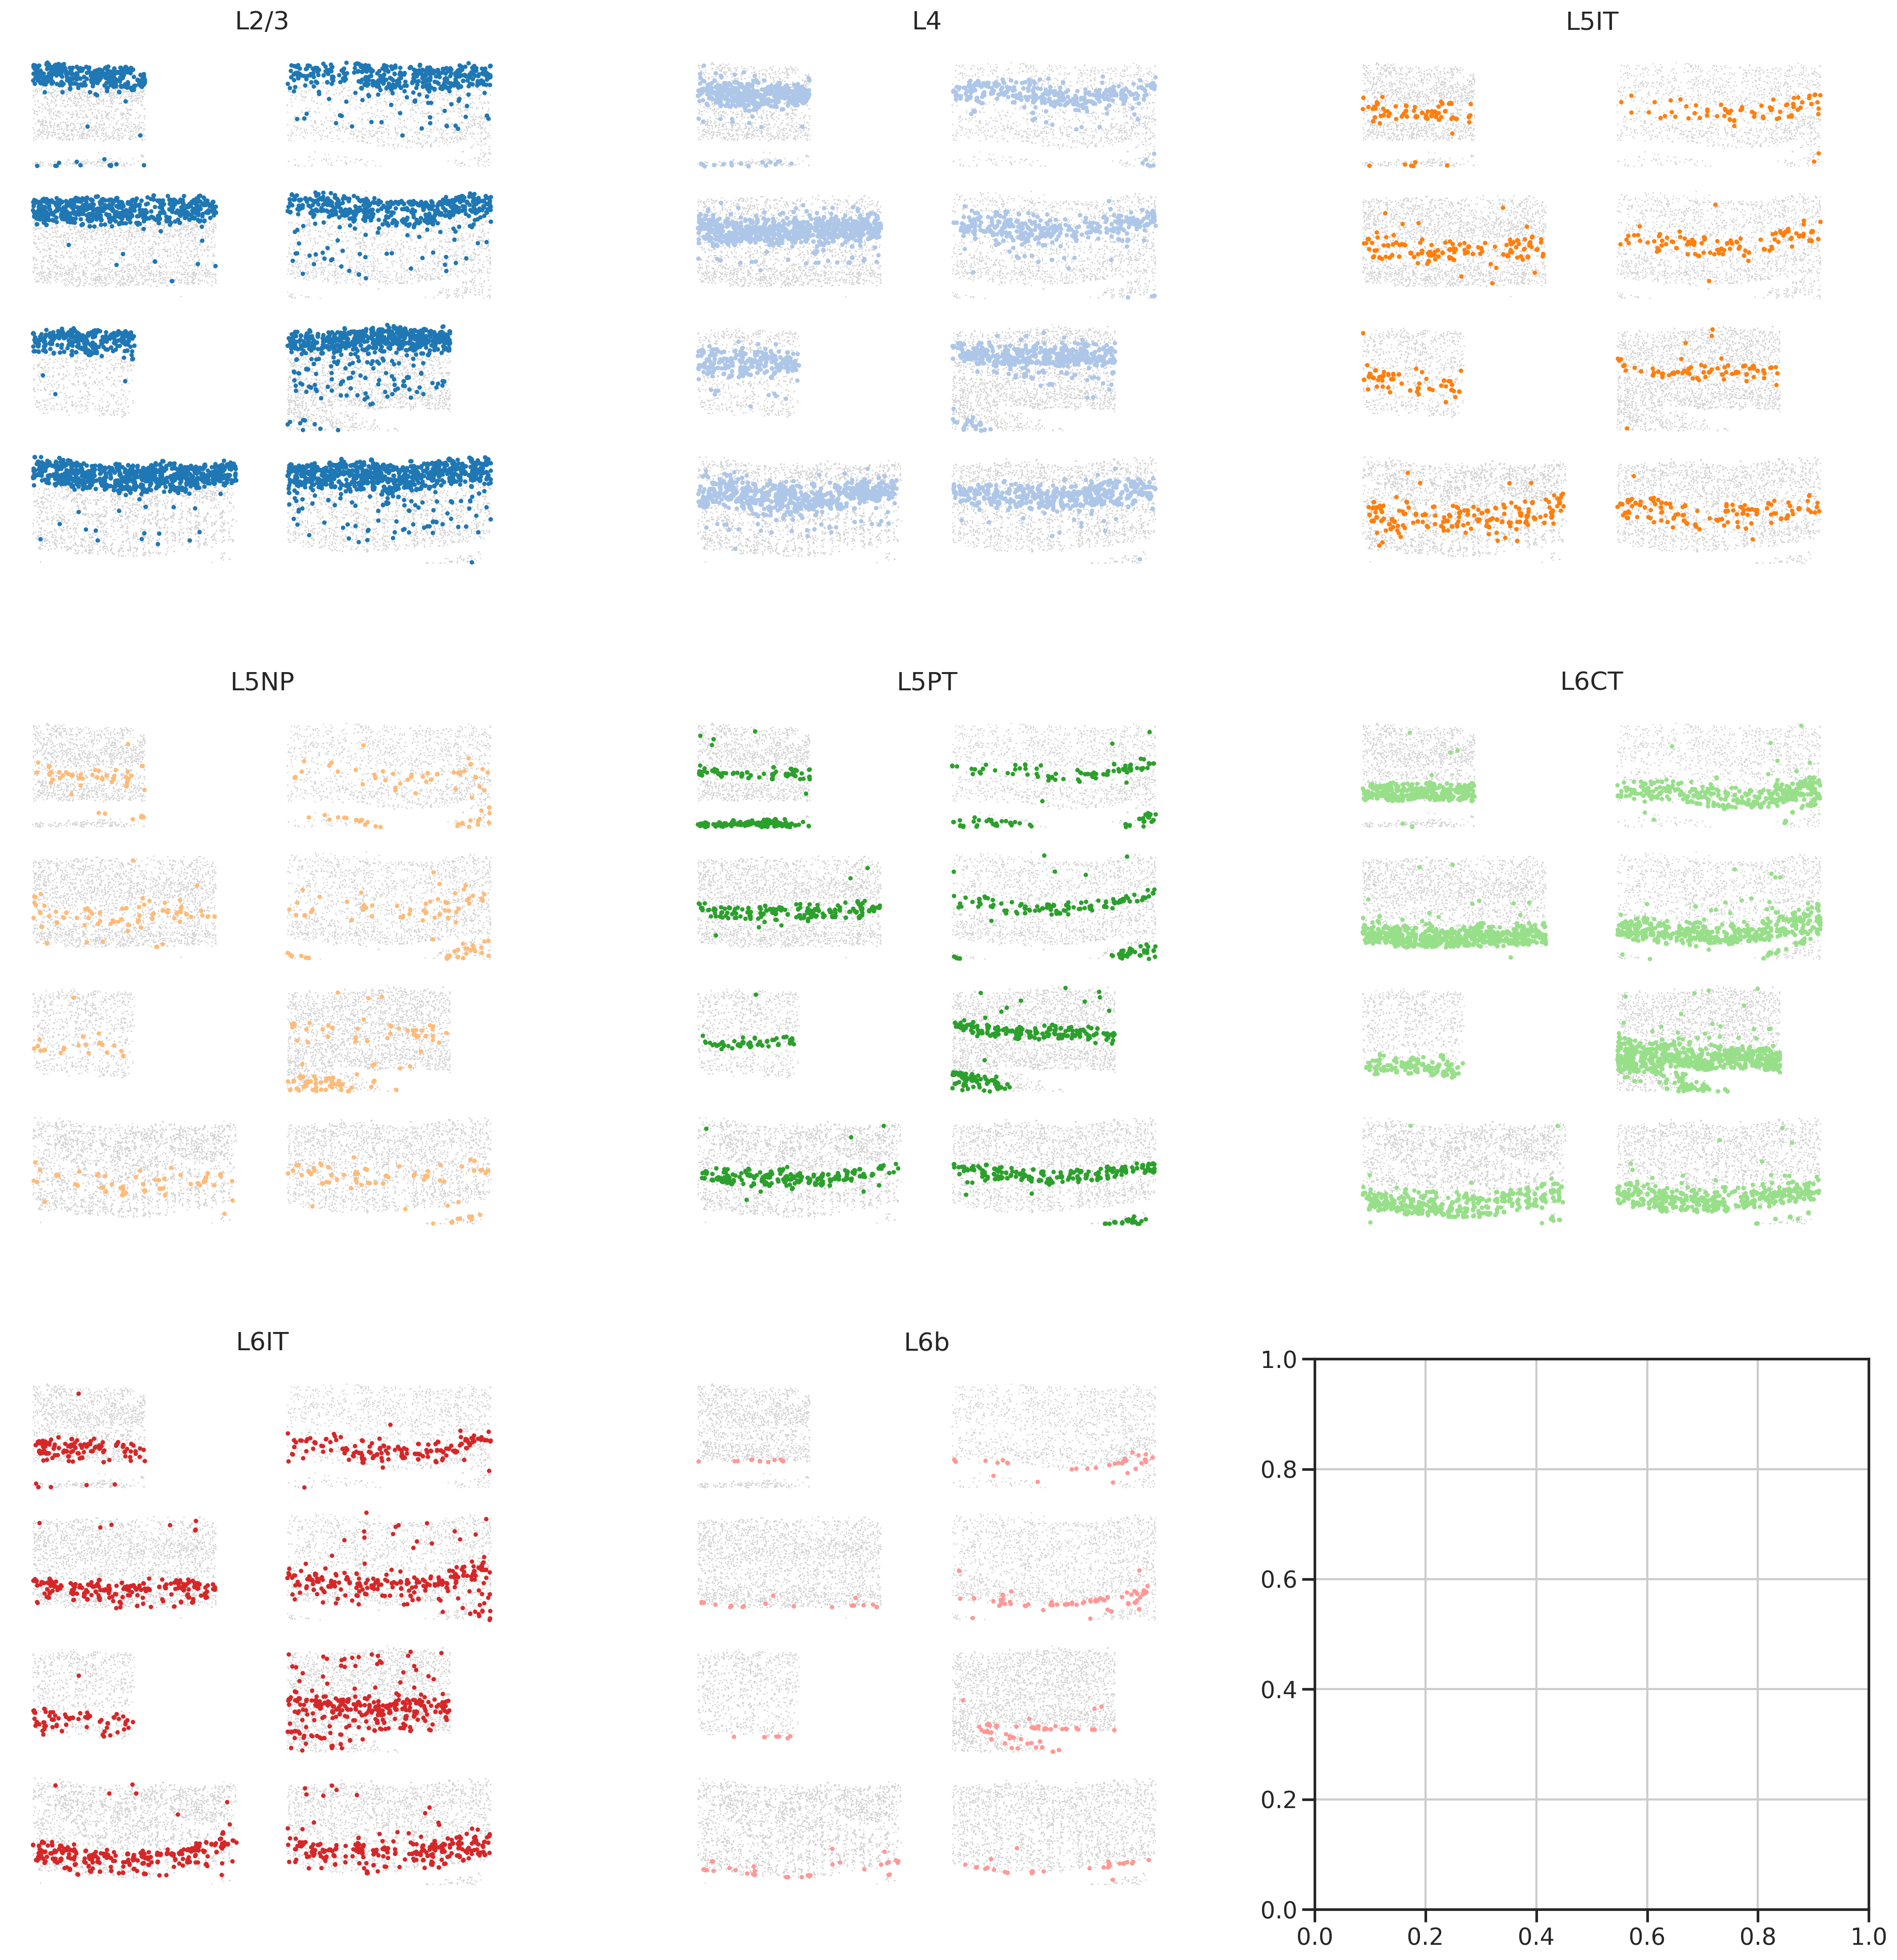

In [27]:
dfshow = adata_merfish.obs.sample(frac=1, replace=False).copy()
types = list(clsts_palette3.keys()) # dfshow['gated_pred'].unique()
print(types)

fig, axs = plt.subplots(3,3,figsize=(8*3,8*3))
for i, ax in enumerate(axs.flat):
    thistype = types[i]
    
    ax.set_title(thistype)
    sns.scatterplot(data=dfshow, 
                    x='width_show', y='depth_show', 
                    color='lightgray',
                    s=1, edgecolor='none', ax=ax, rasterized=True)
    
    sns.scatterplot(data=dfshow[dfshow['max_pred_subclass']==thistype], 
                    x='width_show', y='depth_show', 
                    color=clsts_palette3[thistype],
                    s=10, edgecolor='none', ax=ax, rasterized=True)
    ax.axis('off')
    ax.set_aspect('equal')
    # ax.invert_yaxis()
    
    # break
    
# ax.legend(bbox_to_anchor=(1,1), fontsize=10)
# # powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_dw.pdf'))
# plt.show()

In [ ]:
bins = np.linspace(0,1000,40+1)

fig, ax = plt.subplots() #figsize=(8,4))
for i, thistype in enumerate(types):
    dfshow_sub = dfshow[dfshow['max_pred_subclass']==thistype]
    sns.histplot(dfshow_sub['depth'], bins=bins, element='step', fill=False, 
                 # stat='percent',
                 color=clsts_palette3[thistype], 
                 label=thistype,
                 # kde=True,
                 ax=ax, 
                )
    
ax.set_xlim([0,1000])
# ax.set_ylim([0,12])
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.grid(False)
ax.set_ylabel('Num. cells')
powerplots.savefig_autodate(fig, os.path.join(outdir, 'fig1_hist.pdf'))
plt.show()